In [1]:
import sys
sys.path.append(r'/home1/roeyshafran/BrainCap/Mind-Cap/code/Mind_Vis_utils/')

from fmri_caption import GPTCaptionModel, create_fmri_encoder_from_pretrained,top_k_top_p_filtering, set_parameter_requires_grad
from dataset import BOLD5000_dataset, identity
from dataset import create_BOLD5000_dataset
from torch.utils.data import DataLoader, Subset
import torch
import torch.optim as optim
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer, util
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import heapq
from datetime import datetime
#import optuna
%matplotlib inline

#### Setup

In [2]:
# Parameters
BATCH_SIZE = 8
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
LEARNING_RATE = 1.25e-5
NUM_EPOCHS = 16
TRIAL_NUM_TRAIN_EXAMPLES = BATCH_SIZE*30
TRIAL_NUM_VAL_EXAMPLES = BATCH_SIZE*10
WARMUP_STEPS = 2000

cuda:0


In [3]:
# Pretrained files
path_fmri_encoder = r"/databases/roeyshafran/BrainCap/pretrains/pretrain_metafile.pth"
#path_BOLD_dataset = r"/databases/roeyshafran/BrainCap/data/BOLD5000/CSI1_dataset.pth"
path_BOLD_dataset = r"/databases/roeyshafran/BrainCap/data/CSI1_no_duplicates.pth"

# create BOLD5000 dataset
BOLD_dataset = torch.load(path_BOLD_dataset)
bold_train, bold_test = BOLD_dataset['train'], BOLD_dataset['test']
#num_voxels = bold_test.num_voxels
num_voxels = 1696


In [4]:
print(f"Original train len: {len(bold_train)}, Original test len {len(bold_test)}")

Original train len: 2154, Original test len 52


In [5]:
train_idx, val_idx = train_test_split(list(range(len(bold_train))),test_size=0.1)
bold_val = Subset(bold_train, val_idx)
bold_train = Subset(bold_train, train_idx)

train_dl = DataLoader(bold_train, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(bold_val, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(bold_test, batch_size=BATCH_SIZE, shuffle=True)

print(f"Train len: {len(bold_train)}, val len: {len(bold_val)}")


Train len: 1938, val len: 216


In [6]:
def remove_duplicates_from_dataset(dataloader):
    prev_seen = {
            'caption': np.array([]),
            'image': torch.tensor([]).to(device),
            'fmri': torch.tensor([]).to(device)
        }
    for batch in dataloader:
        #batch['fmri'] = batch['fmri'].to(device)
        #batch['image'] = batch['image'].to(device)
        remove_duplicates_in_batch(batch) # in-place
        remove_previously_seen_fmri(batch, prev_seen, device) # in-place
        
        try:
            prev_seen['caption'] = np.concatenate((prev_seen['caption'], batch['caption']))
        except:
            prev_seen['caption'] = np.concatenate((prev_seen['caption'], [batch['caption']]))
        prev_seen['image'] = torch.cat((prev_seen['image'], batch['image'].to(device)), dim=0)
        prev_seen['fmri'] = torch.cat((prev_seen['fmri'], batch['fmri'].to(device)), dim=0)

    #return [dict(zip(prev_seen,t)) for t in zip(*prev_seen.values())]
    return BOLD5000_dataset(prev_seen['fmri'].cpu(), prev_seen['caption'].cpu(), prev_seen['image'].cpu(), identity, identity, num_voxels)

print(f"With duplicates: Train len: {len(bold_train)}, Test len: {len(bold_test)}")
bold_train = remove_duplicates_from_dataset(train_dl)
bold_test = remove_duplicates_from_dataset(test_dl)
print(f"No duplicates: Train len: {len(bold_train)}, Test len: {len(bold_test)}")



With duplicates: Train len: 1938, Test len: 52


NameError: name 'remove_duplicates_in_batch' is not defined

In [6]:
num_voxels = 1696

In [ ]:


to_save = {'train': bold_train, 'test': bold_test}
torch.save(to_save, r"/databases/roeyshafran/BrainCap/data/CSI1_no_duplicates.pth")

#### Function Delerations

In [6]:
@torch.no_grad()
def calculate_semantic_similarity(generated_caption, real_caption, device):
    sentence_model = SentenceTransformer('all-mpnet-base-v2').to(device)
    embed_generated = sentence_model.encode(generated_caption, convert_to_tensor=True)
    embed_real_caption = sentence_model.encode(real_caption, convert_to_tensor=True)
      
    return torch.diagonal(util.pytorch_cos_sim(embed_generated, embed_real_caption))

def define_GPTCaption_model(encoder, trial=None, projection_sizes=None, use_dropout=False):
    if trial:
        # TODO: Add Optuna support. If trial is used, override projection_sizes with Optuna suggestion
        num_layers = trial.suggest_int("num_projection_layers", 1, 5)
        projection_sizes = [encoder.embed_dim]*num_layers
    gpt_decoder = GPTCaptionModel(encoder.num_patches, encoder.embed_dim, projection_sizes, use_dropout=use_dropout)
    set_parameter_requires_grad(gpt_decoder.embedding_space_projection, feature_extraction=False)
    set_parameter_requires_grad(gpt_decoder.gpt, feature_extraction=True)
    #set_parameter_requires_grad(gpt_decoder.tokenizer, feature_extraction=True)
    #for param in gpt_decoder.tokenizer.parameters():
    #  param.requires_grad = False

    return gpt_decoder

def print_batch(batch, fontsize=5, num_of_columns=5, caption_as_title=False):
    N = int(np.ceil(np.sqrt(len(batch))))
    num_of_plots = len(batch)
    num_of_rows = num_of_plots // num_of_columns
    fig, axs = plt.subplots(num_of_rows, num_of_columns)
    if hasattr(axs, '__iter__'):
        axs = axs.flatten()
    else:
        axs = [axs]
    for idx, ax in enumerate(axs):
        try:
            ax.imshow(batch[idx]['image'])
            str_to_show = f"({idx}) Generated: {batch[idx]['caption']}\n   Real: {batch[idx]['real_caption']}  Accuracy: {batch[idx]['accuracy']}"
            if caption_as_title:
                ax.set_title(str_to_show, fontsize=fontsize)
            else:
                print(str_to_show)
        except IndexError:
            pass
        ax.set_xticks([],[])
        ax.set_yticks([],[])
      
    fig.tight_layout()



@torch.no_grad()
def calculate_accuracy_on_test(encoder, decoder, dataloader, device, threshhold=0.5, return_best_batch=False):
    running_accuracy = 0
    above_threshhold_count = 0
    best_accuracy = 0
    for batch in dataloader:
        fmri_prefix = encoder.forward(batch['fmri'].to(device))
        generated_caption = decoder.generate_caption(fmri_prefix, device)

        accuracy_tensor = calculate_semantic_similarity(generated_caption, batch['caption'], device)
        above_threshhold_count += torch.numel(accuracy_tensor[accuracy_tensor >= threshhold])
        accuracy = torch.mean(accuracy_tensor).item()
        running_accuracy += accuracy

        if return_best_batch and (accuracy > best_accuracy):
            best_accuracy = accuracy
            fields = ['accuracy', 'caption', 'real_caption', 'image']
            best_batch = [dict(zip(fields, t)) for t in zip(accuracy_tensor, generated_caption, batch['caption'], batch['image'])]
            #best_batch = list(zip(generated_caption, batch['caption'], batch['image']))

    accuracy = (running_accuracy / len(dataloader), above_threshhold_count / (len(dataloader)*dataloader.batch_size)) 
    if return_best_batch:
        return accuracy, best_batch
    else:
        return accuracy
        
def get_k_best(encoder, decoder, dataloader, k, device):
    k_best = []
    for batch in dataloader:
        remove_duplicates_in_batch(batch) # in-place
        remove_previously_seen_fmri(batch, k_best, device) # in-place
        fmri_prefix = encoder.forward(batch['fmri'].to(device))
        generated_caption = decoder.generate_caption(fmri_prefix, device)
        acc = calculate_semantic_similarity(generated_caption, batch['caption'], device).tolist()
        fields = ['accuracy', 'caption', 'real_caption', 'image', 'fmri']
        d = [dict(zip(fields, t)) for t in zip(acc, generated_caption, batch['caption'], batch['image'], batch['fmri'])] # list of {'accuracy':accuracy, 'generated':generated caption, 'real': labeled caption}
        d.extend(k_best)
        k_best = heapq.nlargest(k, d, key=lambda s:s['accuracy'])

    return k_best

def get_k_best_torch(encoder, decoder, dataloader, k, device):
    k_best = {
        'accuracy': torch.tensor([]).to(device),
        'caption': np.array([]),
        'real_caption': np.array([]),
        'image': torch.tensor([]).to(device),
        'fmri': torch.tensor([]).to(device)
    }
    for batch in dataloader:
        #batch['fmri'] = batch['fmri'].to(device)
        #batch['image'] = batch['image'].to(device)
        remove_duplicates_in_batch(batch) # in-place
        remove_previously_seen_fmri(batch, k_best, device) # in-place
        fmri_prefix = encoder.forward(batch['fmri'].to(device))
        generated_caption = decoder.generate_caption(fmri_prefix, device)
        acc = calculate_semantic_similarity(generated_caption, batch['caption'], device)

        k_best['accuracy'] = torch.cat((k_best['accuracy'], acc), dim=0)
        k_best['caption'] = np.concatenate((k_best['caption'], generated_caption))
        k_best['real_caption'] = np.concatenate((k_best['real_caption'], batch['caption']))
        k_best['image'] = torch.cat((k_best['image'], batch['image'].to(device)), dim=0)
        k_best['fmri'] = torch.cat((k_best['fmri'], batch['fmri'].to(device)), dim=0)

        
        k_to_use = min(k_best['accuracy'].size(dim=0), k) 
        topk_values, topk_indices = torch.topk(k_best['accuracy'], k=k_to_use, dim=0) 


        k_best['accuracy'] = k_best['accuracy'][topk_indices]
        k_best['image'] = k_best['image'][topk_indices]
        k_best['fmri'] = k_best['fmri'][topk_indices]
        k_best['caption'] = k_best['caption'][topk_indices.cpu()]
        k_best['real_caption'] = k_best['real_caption'][topk_indices.cpu()]


    return k_best
        

        

def remove_previously_seen_fmri(batch, k_best, device):
    # Works in-line
    #k_best_fmri = torch.tensor([]) if not k_best else torch.cat([torch.unsqueeze(s['fmri'], dim=0) for s in k_best], dim=0)
    #print(batch['fmri'].device)
    #print(k_best['fmri'].device)
    duplicated_mask = torch.isin(batch['fmri'].to(device), k_best['fmri'])[:, 0, 0]
    duplicated_mask = ~duplicated_mask
    batch['fmri'] = batch['fmri'][duplicated_mask]
    batch['image'] = batch['image'][duplicated_mask]
    batch['caption'] = batch['caption'][duplicated_mask.cpu()]

    return


def remove_duplicates_in_batch(batch):
    # Works in-place
    unique_fmri, idx = unique(batch['fmri'], dim=0)
    batch['fmri'] = unique_fmri
    batch['image']  = torch.index_select(batch['image'], dim=0, index=idx)
    batch['caption'] = np.array(batch['caption'])[idx.cpu()]

    return
    

def unique(x, dim=-1):
    unique, inverse = torch.unique(x, return_inverse=True, dim=dim)
    perm = torch.arange(inverse.size(dim), dtype=inverse.dtype, device=inverse.device)
    inverse, perm = inverse.flip([dim]), perm.flip([dim])
    return unique, inverse.new_empty(unique.size(dim)).scatter_(dim, inverse, perm)

def objective(encoder, decoder, train_dl, val_dl, device, trial=None):

    # Generate the optimizers
    if trial:
        lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
        optimizer_name = trial.suggest_categorial("optimizer", ['Adam', 'AdamW', "SGD"])
        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr)
        batch_size = trial.suggest_int("batch_size", 1, 10)
    else:
        lr = LEARNING_RATE
        optimizer = optim.AdamW(encoder.parameters(), lr)
        batch_size = BATCH_SIZE
        #scheduler = get_linear_schedule_with_warmup(
    #optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=NUM_EPOCHS*len(train_dl)
    #)

    decoder.train()
    encoder.eval()
    print("\n\n")
    running_loss = []
    running_semantic_accuracy = []
    val_accuracy = []
    for epoch in range(NUM_EPOCHS):
        print(f"** Starting epoch {epoch} **")
        with tqdm(train_dl, unit='batch') as tepoch:
            semantic_accuracy = 0
            for batch_idx, batch in enumerate(tepoch):
                if batch_idx * batch_size >= TRIAL_NUM_TRAIN_EXAMPLES:
                    break
                
                tepoch.set_description(f"Epoch: {epoch}")

                #batch_fmri = batch['fmri'].to(device)
                batch_fmri = batch['fmri']
                batch_fmri = batch_fmri.to(device)
                batch_caption = batch['caption']

                #print(f">>>> encoding fmri scans ", end="")
                fmri_prefix = encoder.forward(batch_fmri)
                #print(f"-> tokenizing captions ", end="")
                tokens, attention_mask = decoder.tokenizer(batch_caption, return_tensors="pt", padding=True).values()
                tokens, attention_mask, fmri_prefix = tokens.to(device), attention_mask.to(device), fmri_prefix.to(device)
                #print(f"-> decoding ")
                outputs = decoder.forward(tokens, fmri_prefix, attention_mask)
                logits = outputs.logits[:, decoder.prefix_length-1:-1]

                loss = F.cross_entropy(
                    logits.reshape(-1, logits.shape[-1]),
                    tokens.flatten(),
                    ignore_index=decoder.tokenizer.pad_token_id
                      )
                decoder.zero_grad(set_to_none=True)
                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                optimizer.step()
                #scheduler.step()
                #print(f">>>> batch {batch_idx} finished", end="\r")

                # Eval semantic accuracy
                if batch_idx % 10 == 0:
                    with torch.no_grad():
                        generated_caption = decoder.generate_caption(fmri_prefix, device)
                        semantic_accuracy = torch.mean(calculate_semantic_similarity(generated_caption, batch_caption, device)).item()
                        running_semantic_accuracy.append(semantic_accuracy)
                        running_loss.append(loss.item())
                
                tepoch.set_postfix(loss=loss.item(), train_accuracy=semantic_accuracy)

                # Free GPU memory
                del batch_fmri, batch_caption, tokens, attention_mask, logits, outputs, loss
                torch.cuda.empty_cache()
        val_accuracy.append(calculate_accuracy_on_test(encoder, decoder, val_dl, device, return_best_batch=False))
        print(f"---- epoch loss: {np.mean(running_loss[int(np.floor((epoch*len(train_dl))/10 + 1)):-1]):.4}, test accuracy: {np.mean(running_semantic_accuracy[int(np.floor((epoch*len(train_dl))/10 + 1)):-1]):.4}, validation accuracy: {val_accuracy[epoch]:.4} ---- ")

        trial.report(val_accuracy, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_accuracy



#### Optuna Tuning

In [ ]:
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(study_name="BOLD5000-caption", direction="maximize", sampler=sampler)
study.optimie(objective, n_trials=100, timeout=1000)

pruned_trails = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print(" Number of finished trials: ", len(study.trials))
print(" Number of pruned trials: ", len(pruned_trials))
print(" Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print(" Value: ", trial.value)

print(" Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key, value))

In [ ]:
optuna.visualization.plot_param_importance(study)

In [ ]:
optuna.visualization.plot_contour(study, params=['lr', 'batch_size'])

#### Training Loop

In [ ]:
list(decoder.parameters())[0].shape

In [7]:
# Get encoder-decoder
encoder = create_fmri_encoder_from_pretrained(path_fmri_encoder, num_voxels, feature_extraction=True)
encoder = encoder.to(device)
#projection_sizes = [encoder.embed_dim, 2*encoder.embed_dim, 2*encoder.embed_dim, 2*encoder.embed_dim, 2*encoder.embed_dim, 2*encoder.embed_dim, 
#4*encoder.embed_dim, 4*encoder.embed_dim, 2*encoder.embed_dim]
projection_sizes = [encoder.embed_dim,4*encoder.embed_dim, 4*encoder.embed_dim,4*encoder.embed_dim, 2*encoder.embed_dim]
decoder = define_GPTCaption_model(encoder, projection_sizes=projection_sizes, use_dropout=True)

Position interpolate from 262 to 106
missing keys: ['mask_token']
unexpected keys: ['decoder_pos_embed', 'decoder_embed.weight', 'decoder_embed.bias', 'decoder_blocks.0.norm1.weight', 'decoder_blocks.0.norm1.bias', 'decoder_blocks.0.attn.qkv.weight', 'decoder_blocks.0.attn.qkv.bias', 'decoder_blocks.0.attn.proj.weight', 'decoder_blocks.0.attn.proj.bias', 'decoder_blocks.0.norm2.weight', 'decoder_blocks.0.norm2.bias', 'decoder_blocks.0.mlp.fc1.weight', 'decoder_blocks.0.mlp.fc1.bias', 'decoder_blocks.0.mlp.fc2.weight', 'decoder_blocks.0.mlp.fc2.bias', 'decoder_blocks.1.norm1.weight', 'decoder_blocks.1.norm1.bias', 'decoder_blocks.1.attn.qkv.weight', 'decoder_blocks.1.attn.qkv.bias', 'decoder_blocks.1.attn.proj.weight', 'decoder_blocks.1.attn.proj.bias', 'decoder_blocks.1.norm2.weight', 'decoder_blocks.1.norm2.bias', 'decoder_blocks.1.mlp.fc1.weight', 'decoder_blocks.1.mlp.fc1.bias', 'decoder_blocks.1.mlp.fc2.weight', 'decoder_blocks.1.mlp.fc2.bias', 'decoder_blocks.2.norm1.weight', 'dec

In [13]:
#decoder = decoder.to(device)
optimizer = optim.AdamW(decoder.parameters(), lr=LEARNING_RATE, weight_decay=0.2)
#scheduler = get_linear_schedule_with_warmup(
#    optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=NUM_EPOCHS*len(train_dl)
#    )

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [1], gamma=0.5, verbose=True)
use_amp = False
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

Adjusting learning rate of group 0 to 1.2500e-05.


In [22]:
# Train
decoder.train()
encoder.eval()
decoder.to(device)
print("\n\n")
#running_loss = []
#running_semantic_accuracy = []
#val_accuracy = []
#lr_monitor = []
for epoch in range(NUM_EPOCHS):
    print(f"** Starting epoch {epoch} **")
    decoder.train()
    with tqdm(train_dl, unit='batch') as tepoch:
      semantic_accuracy = 0
      for batch_idx, batch in enumerate(tepoch):
          decoder.train()
          tepoch.set_description(f"Epoch: {epoch}")

          #batch_fmri = batch['fmri'].to(device)
          batch_fmri = batch['fmri']
          batch_fmri = batch_fmri.to(device)
          batch_caption = batch['caption']

          with torch.cuda.amp.autocast(enabled=use_amp):
            #print(f">>>> encoding fmri scans ", end="")
            fmri_prefix = encoder.forward(batch_fmri)
            #print(f"-> tokenizing captions ", end="")
            tokens, attention_mask = decoder.tokenizer(batch_caption, return_tensors="pt", padding=True).values()
            tokens, attention_mask, fmri_prefix = tokens.to(device), attention_mask.to(device), fmri_prefix.to(device)
            #print(f"-> decoding ")
            outputs = decoder.forward(tokens, fmri_prefix, attention_mask)
            logits = outputs.logits[:, decoder.prefix_length-1:-1]
            loss = F.cross_entropy(logits.reshape(-1, logits.shape[-1]), tokens.flatten(), ignore_index=decoder.tokenizer.pad_token_id)

          decoder.zero_grad(set_to_none=True)
          optimizer.zero_grad(set_to_none=True)
          scaler.scale(loss).backward()
          scaler.step(optimizer)
          scaler.update()
          
          #print(f">>>> batch {batch_idx} finished", end="\r")

          # Eval semantic accuracy
          if batch_idx % 10 == 0:
            decoder.eval()
            with torch.no_grad():
              generated_caption = decoder.generate_caption(fmri_prefix, device)
              semantic_accuracy = torch.mean(calculate_semantic_similarity(generated_caption, batch_caption, device)).item()
              running_semantic_accuracy.append(semantic_accuracy)
              running_loss.append(loss.item())
              lr_monitor.append(scheduler.get_last_lr())
          
          tepoch.set_postfix(loss=loss.item(), train_accuracy=semantic_accuracy)

          # Free GPU memory
          del batch_fmri, batch_caption, tokens, attention_mask, logits, outputs, loss
          torch.cuda.empty_cache()
    decoder.eval()
    val_accuracy.append(calculate_accuracy_on_test(encoder, decoder, val_dl, device, return_best_batch=False))
    print(f"---- epoch {epoch} loss: {np.mean(running_loss[int(np.floor((epoch*len(train_dl))/10 + 1)):-1]):.4}, train accuracy: {np.mean(running_semantic_accuracy[int(np.floor((epoch*len(train_dl))/10 + 1)):-1]):.4}, validation accuracy (running, % above thresh): {val_accuracy[-1]} ---- ")
    #scheduler.step()





** Starting epoch 0 **


Epoch: 0: 100%|██████████| 243/243 [01:33<00:00,  2.60batch/s, loss=3.34, train_accuracy=0.25] 


---- epoch 0 loss: 3.459, train accuracy: 0.155, validation accuracy (running, % above thresh): (0.20597379240724775, 0.09722222222222222) ---- 
** Starting epoch 1 **


Epoch: 1: 100%|██████████| 243/243 [01:31<00:00,  2.66batch/s, loss=3.62, train_accuracy=0.244]


---- epoch 1 loss: 3.432, train accuracy: 0.1566, validation accuracy (running, % above thresh): (0.18829780209947516, 0.05555555555555555) ---- 
** Starting epoch 2 **


Epoch: 2: 100%|██████████| 243/243 [01:24<00:00,  2.88batch/s, loss=4.04, train_accuracy=0.189]


---- epoch 2 loss: 3.411, train accuracy: 0.1578, validation accuracy (running, % above thresh): (0.1933158845813186, 0.05555555555555555) ---- 
** Starting epoch 3 **


Epoch: 3: 100%|██████████| 243/243 [01:26<00:00,  2.82batch/s, loss=3.68, train_accuracy=0.172]


---- epoch 3 loss: 3.39, train accuracy: 0.1592, validation accuracy (running, % above thresh): (0.1923173431445051, 0.06018518518518518) ---- 
** Starting epoch 4 **


Epoch: 4: 100%|██████████| 243/243 [01:23<00:00,  2.90batch/s, loss=2.75, train_accuracy=0.294]


---- epoch 4 loss: 3.372, train accuracy: 0.1604, validation accuracy (running, % above thresh): (0.20090154530825438, 0.06481481481481481) ---- 
** Starting epoch 5 **


Epoch: 5: 100%|██████████| 243/243 [01:32<00:00,  2.64batch/s, loss=2.71, train_accuracy=0.179]


---- epoch 5 loss: 3.352, train accuracy: 0.1616, validation accuracy (running, % above thresh): (0.19202807352498727, 0.041666666666666664) ---- 
** Starting epoch 6 **


Epoch: 6: 100%|██████████| 243/243 [01:29<00:00,  2.73batch/s, loss=2.82, train_accuracy=0.146]


---- epoch 6 loss: 3.332, train accuracy: 0.163, validation accuracy (running, % above thresh): (0.179020453106474, 0.041666666666666664) ---- 
** Starting epoch 7 **


Epoch: 7: 100%|██████████| 243/243 [01:32<00:00,  2.61batch/s, loss=3.56, train_accuracy=0.2]  


---- epoch 7 loss: 3.312, train accuracy: 0.164, validation accuracy (running, % above thresh): (0.19798416258008392, 0.07407407407407407) ---- 
** Starting epoch 8 **


Epoch: 8: 100%|██████████| 243/243 [01:27<00:00,  2.76batch/s, loss=2.66, train_accuracy=0.372]


---- epoch 8 loss: 3.298, train accuracy: 0.1656, validation accuracy (running, % above thresh): (0.1996572506096628, 0.06944444444444445) ---- 
** Starting epoch 9 **


Epoch: 9: 100%|██████████| 243/243 [01:33<00:00,  2.61batch/s, loss=2.98, train_accuracy=0.243]


---- epoch 9 loss: 3.293, train accuracy: 0.1666, validation accuracy (running, % above thresh): (0.18176017453273138, 0.037037037037037035) ---- 
** Starting epoch 10 **


Epoch: 10: 100%|██████████| 243/243 [01:27<00:00,  2.79batch/s, loss=2.24, train_accuracy=0.298]


---- epoch 10 loss: 3.289, train accuracy: 0.1679, validation accuracy (running, % above thresh): (0.1846991506991563, 0.037037037037037035) ---- 
** Starting epoch 11 **


Epoch: 11: 100%|██████████| 243/243 [01:27<00:00,  2.77batch/s, loss=3.31, train_accuracy=0.23] 


---- epoch 11 loss: 3.285, train accuracy: 0.169, validation accuracy (running, % above thresh): (0.20161647735922425, 0.05555555555555555) ---- 
** Starting epoch 12 **


Epoch: 12: 100%|██████████| 243/243 [01:33<00:00,  2.61batch/s, loss=3.49, train_accuracy=0.275]


---- epoch 12 loss: 3.28, train accuracy: 0.1704, validation accuracy (running, % above thresh): (0.18130875572010322, 0.046296296296296294) ---- 
** Starting epoch 13 **


Epoch: 13: 100%|██████████| 243/243 [01:24<00:00,  2.87batch/s, loss=4.19, train_accuracy=0.244]


---- epoch 13 loss: 3.275, train accuracy: 0.1717, validation accuracy (running, % above thresh): (0.20275433913425164, 0.06944444444444445) ---- 
** Starting epoch 14 **


Epoch: 14: 100%|██████████| 243/243 [01:26<00:00,  2.82batch/s, loss=4.16, train_accuracy=0.165]


---- epoch 14 loss: 3.27, train accuracy: 0.1731, validation accuracy (running, % above thresh): (0.183696114078716, 0.041666666666666664) ---- 
** Starting epoch 15 **


Epoch: 15: 100%|██████████| 243/243 [01:23<00:00,  2.90batch/s, loss=3.37, train_accuracy=0.232]


---- epoch 15 loss: 3.267, train accuracy: 0.1744, validation accuracy (running, % above thresh): (0.19616503102911842, 0.06018518518518518) ---- 


#### Save Model

In [24]:
decoder.eval()
acc, above_threshold = calculate_accuracy_on_test(encoder, decoder, test_dl, device, return_best_batch=False)
print(acc, above_threshold)

0.19909353128501348 0.07142857142857142


In [25]:
to_save = {
    'comment': "Small architecture on the CSI1_no_duplicates set. Transfer learning from no_dup_encoder_0.1555_0.01389_0.1748_22012023_09-45-51.pth. 16+16+16 epochs with lr=1.25e-5 Dropout=0.3. with decoder.eval(). started overfitting again. Last checkpoint ended with higher accuracy on test.",
    'hyperparameters': {'batch_size': BATCH_SIZE},
    'decoder_projection': {'sizes': decoder.projection_sizes, 'sd': decoder.embedding_space_projection.state_dict()},
    'optimizer': {'type': type(optimizer), 'sd': optimizer.state_dict()['param_groups']},
    'scheduler': {'type': type(scheduler), 'sd': scheduler.state_dict()},
    'training_data': {
        "running_loss": running_loss,
        'running_semantic_accuracy': running_semantic_accuracy,
        'val_accuracy': val_accuracy,
        'lr_monitor': lr_monitor
    }
}

now = datetime.now()
dt_string = now.strftime("%d%m%Y_%H-%M-%S")
torch.save(to_save, f'/databases/roeyshafran/BrainCap/Checkpoints/no_dup_encoder_{val_accuracy[-1][0]:.4}_{val_accuracy[-1][1]:.4}_{acc:.4}_{dt_string}.pth')

#### Load Model

In [11]:
model_dict = torch.load(r'/databases/roeyshafran/BrainCap/Checkpoints/no_dup_encoder_0.189_0.05556_0.18_22012023_12-20-13.pth')
#model_dict = torch.load(r'/databases/roeyshafran/BrainCap/Checkpoints/encoder_0.1626_0.02778_20012023_11-54-46.pth')
#loaded_decoder.load_state_dict(model_dict['decoder'])

In [12]:
print(model_dict.keys())
print(model_dict['comment'])
#decoder.embedding_space_projection.load_state_dict(model_dict['decoder_projection']['sd'])
running_loss = model_dict['training_data']['running_loss']
running_semantic_accuracy = model_dict['training_data']['running_semantic_accuracy']
val_accuracy = model_dict['training_data']['val_accuracy']
lr_monitor = model_dict['training_data']['lr_monitor']
#scheduler.load_state_dict(model_dict['scheduler']['sd'])
#optimizer.load_state_dict(model_dict['optimizer'])
new_sd = state_dict_MLP_to_MLP_dropout(decoder.embedding_space_projection.state_dict(), model_dict['decoder_projection']['sd'])
print(decoder.embedding_space_projection.load_state_dict(new_sd))
set_parameter_requires_grad(decoder.embedding_space_projection, feature_extraction=False)
del model_dict
torch.cuda.empty_cache()

dict_keys(['comment', 'hyperparameters', 'decoder_projection', 'optimizer', 'scheduler', 'training_data'])
Small architecture on the CSI1_no_duplicates set. Transfer learning from no_dup_encoder_0.1555_0.01389_0.1748_22012023_09-45-51.pth. Adding 8 epochs with last lr=1.25e-5 and weigth_decay=0.2
<All keys matched successfully>


In [10]:
print(decoder.embedding_space_projection.state_dict().keys())
print(model_dict['decoder_projection']['sd'].keys())

def state_dict_MLP_to_MLP_dropout(projection_state_dict, MLP_state_dict):
    new_keys = dict(zip(MLP_state_dict.keys(), projection_state_dict.keys()))
    new_sd = dict((new_keys[key], value) for (key, value) in MLP_state_dict.items())

    return new_sd
    
#new_sd = state_dict_MLP_to_MLP_dropout(decoder.embedding_space_projection.state_dict(), model_dict['decoder_projection']['sd'])

odict_keys(['model.0.weight', 'model.0.bias', 'model.3.weight', 'model.3.bias', 'model.6.weight', 'model.6.bias', 'model.9.weight', 'model.9.bias', 'model.12.weight', 'model.12.bias'])
odict_keys(['model.0.weight', 'model.0.bias', 'model.2.weight', 'model.2.bias', 'model.4.weight', 'model.4.bias', 'model.6.weight', 'model.6.bias', 'model.8.weight', 'model.8.bias'])


In [15]:
decoder.embedding_space_projection.model

Sequential(
  (0): Linear(in_features=1024, out_features=4096, bias=True)
  (1): Dropout(p=0.3, inplace=False)
  (2): Tanh()
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): Dropout(p=0.3, inplace=False)
  (5): Tanh()
  (6): Linear(in_features=4096, out_features=4096, bias=True)
  (7): Dropout(p=0.3, inplace=False)
  (8): Tanh()
  (9): Linear(in_features=4096, out_features=2048, bias=True)
  (10): Dropout(p=0.3, inplace=False)
  (11): Tanh()
  (12): Linear(in_features=2048, out_features=768, bias=True)
  (13): Dropout(p=0.3, inplace=False)
)

#### Visualize Results

In [72]:
scheduler.get_last_lr()

[1.25e-05]

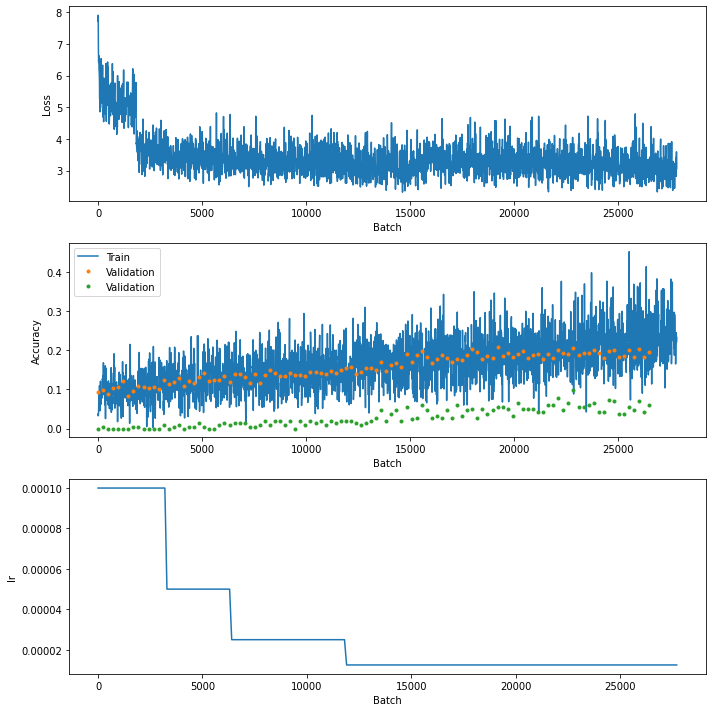

In [23]:
fig, axs = plt.subplots(3,1, figsize=(10,10))
axs = axs.flatten()
#batch_iterations = np.arange(0, len(train_dl)*NUM_EPOCHS+1, 10)
batch_iterations = np.arange(0, len(running_loss)*10, 10)
val_iterations = np.arange(0, len(val_accuracy)*len(train_dl), len(train_dl))
axs[0].plot(batch_iterations, running_loss)
axs[0].set_xlabel('Batch')
axs[0].set_ylabel('Loss')

axs[1].plot(batch_iterations, running_semantic_accuracy, label='Train')
#axs[1].plot(batch_iterations[0:-1:int(np.ceil(len(running_loss)/10))], val_accuracy, '.', label='Validation')
axs[1].plot(val_iterations, val_accuracy, '.', label='Validation')
axs[1].set_xlabel('Batch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

axs[2].plot(batch_iterations[:-1:10], np.array(lr_monitor).squeeze()[0:-1:10])
axs[2].set_xlabel('Batch')
axs[2].set_ylabel('lr')

#axs[3].plot(batch_iterations[:-1], val_accuracy)
#axs[3].set_xlabel('Batch')
#axs[3].set_ylabel('lr')

fig.tight_layout() 



In [27]:
decoder.to(device)
decoder.eval()
# acc_test, above_thresh_test = calculate_accuracy_on_test(encoder, decoder, test_dl, device, return_best_batch=False)
# acc_val, above_thresh_val = calculate_accuracy_on_test(encoder, decoder, val_dl, device, return_best_batch=False)
# acc_train, above_thresh_train = calculate_accuracy_on_test(encoder, decoder, train_dl, device, return_best_batch=False)

print(f"Train: {acc_train}, {above_thresh_train*100}%")
print(f"Validaion: {acc_val}, {above_thresh_val*100}%")
print(f"Test: {acc_test}, {above_thresh_test*100}%")


Train: 0.25430243492984966, 12.911522633744857%
Validaion: 0.18648146203270666, 4.62962962962963%
Test: 0.20712204703262874, 8.928571428571429%


In [15]:
# print(f"Train: {acc_train}, {above_thresh_train*100}%")
# print(f"Validaion: {acc_train}, {bove_thresh_val*100}%")
print(f"Test: {acc_test}, {above_thresh_test*100}%")

Test: 0.17996880837849208, 5.357142857142857%


In [26]:
for batch in test_dl:
    bt = batch
    break
for batch in val_dl:
    bv = batch
    break

In [35]:
best_k_train = get_k_best(encoder, decoder, train_dl, 10, device)

TypeError: list indices must be integers or slices, not str

In [12]:
#acc, best_batch = calculate_accuracy_on_test(encoder, decoder, test_dl, device, return_best_batch=True)
best_k_val = get_k_best_torch(encoder, decoder, val_dl, 2, device)
best_k_train = get_k_best_torch(encoder, decoder, train_dl, 2, device)
best_k_test = get_k_best_torch(encoder, decoder, test_dl, 2, device)

In [13]:

# best_k_train['image'] = best_k_train['image'].cpu()
# best_k_train['fmri'] = best_k_train['fmri'].cpu()
# best_k_train['accuracy'] = best_k_train['accuracy'].cpu()
# best_k_train_records = [dict(zip(best_k_train,t)) for t in zip(*best_k_train.values())]

best_k_test['image'] = best_k_test['image'].cpu()
best_k_test['fmri'] = best_k_test['fmri'].cpu()
best_k_test['accuracy'] = best_k_test['accuracy'].cpu()
best_k_test_records = [dict(zip(best_k_test,t)) for t in zip(*best_k_test.values())]

# best_k_val['image'] = best_k_val['image'].cpu()
# best_k_val['fmri'] = best_k_val['fmri'].cpu()
# best_k_val['accuracy'] = best_k_val['accuracy'].cpu()
# best_k_val_records = [dict(zip(best_k_val,t)) for t in zip(*best_k_val.values())]


(0) Generated: <|endoftext|>In an adjacent restaurant serving sandwiches and salads, the chef's table is standing outside the kitchen door.
   Real: A table topped with cut in half sandwiches and salads.  Accuracy: 0.5404351949691772
(1) Generated: <|endoftext|>A small bathroom with a shower where a woman and a man works on a toilet.
   Real: A standing shower with a see through glass door.  Accuracy: 0.48586899042129517
(2) Generated: <|endoftext|>a small room with a refrigerator and food sink in it.
   Real: A white bathroom with a toilet, sink, mirror and shower curtain.  Accuracy: 0.43441200256347656
(3) Generated: <|endoftext|>There is a giraffe near a herd.
   Real: There is an elephant that is walking around   Accuracy: 0.38197746872901917
(4) Generated: <|endoftext|>walnut mignon sitting on its back and fruits in a box.
   Real: A yummy looking sandwich with french fries on foil.  Accuracy: 0.3745367228984833
(5) Generated: <|endoftext|>A pizza stands on the ground and next to 

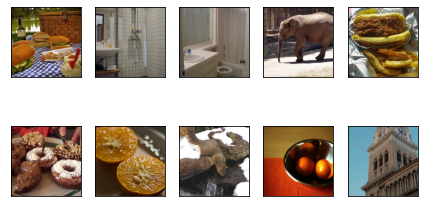

In [14]:
print_batch(best_k_test_records, fontsize=10, num_of_columns=5, caption_as_title=False)

(0) Generated: <|endoftext|>a man is playing a guitar and a small rock riding on a sidewalk.
   Real: A man is sitting on a sidewalk playing guitar.  Accuracy: 0.7802342772483826
(1) Generated: <|endoftext|>A small kitchen sitting on the living room wall in the living room.
   Real: A small kitchen with a sink and stove.  Accuracy: 0.7185066938400269
(2) Generated: <|endoftext|>A red, oval shaped sign stands in the street.
   Real: A red stop sign sitting on the side of a road.  Accuracy: 0.6973899602890015
(3) Generated: <|endoftext|>a hamburger placed across from a pile of empty hamburgers.
   Real: a plate with a half eaten hamburger and baked beans.
  Accuracy: 0.6659550666809082
(4) Generated: <|endoftext|>a giraffe standing alone in a forest   standing on the ground    bowie bowie bowie bowie bowie bowie bowie bowie bowie bowie bowie bowie bowie bowie bowie bowie bowie bowie bowie bowie bowie bowie bowie bowie bowie bowie bowie bowie bowie bowie bowie bowie bowie bowie bowie bowi

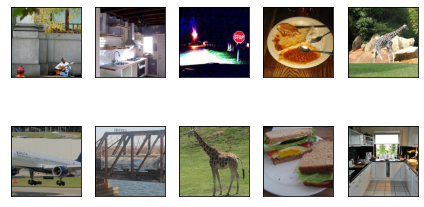

In [40]:
print_batch(best_k_train_records, fontsize=10, num_of_columns=5, caption_as_title=False)


(0) Generated: <|endoftext|>a zebra and zebras standing near each other.
   Real: Three zebras standing together in a grassy field.  Accuracy: 0.7549365758895874
(1) Generated: <|endoftext|>a bathroom with the sink and vanity sitting on top of it.
   Real: A bathroom with a bunch of accessories and bathroom furniture  Accuracy: 0.6336899995803833
(2) Generated: <|endoftext|>a large, large banana with large stone, gray satin tufted scarf under its end, and sandalwood wood around it.
   Real: A wire basket with apples and bananas in it.  Accuracy: 0.5934107899665833
(3) Generated: <|endoftext|>A giraffe walking along a tree.
   Real: Giraffes huddled next to a tree in their natural environment.  Accuracy: 0.5786381959915161
(4) Generated: <|endoftext|>A kitchen with enough seating to accommodate 2 people.
   Real: A kitchen with microwave, stove and coffee maker.  Accuracy: 0.5644310712814331
(5) Generated: <|endoftext|>A sandwich sitting on a table eating its breakfast cereal.
   Real: 

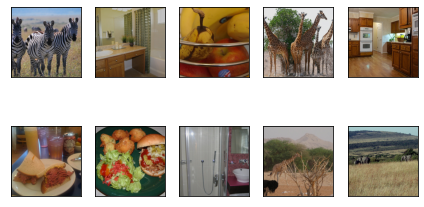

In [41]:
print_batch(best_k_val_records, fontsize=10, num_of_columns=5, caption_as_title=False)